In [113]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import statsmodels.sandbox.stats.multicomp as sm
from scipy.stats import spearmanr

In [114]:
data = pd.read_csv(os.path.join('data', 'Pokemon.csv'))
data['Type 2']=data['Type 2'].replace('NaN', 'no')
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [115]:
legendaries = data[data['Legendary']==True]
commons = data[data['Legendary']==False]

## Legendaries

In [116]:
print('number :', len(legendaries))
print('average total stats :', np.mean(legendaries['Total']))
for stat in ['HP', 'Attack','Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    print('average', stat, ':', np.mean(legendaries[stat]))
print('Number of legendaries per type :', Counter(legendaries['Type 1']))
print('Number of legendaries per generation :', Counter(legendaries['Generation']))
#print('IDs :', list(legendaries['#']))

number : 75
average total stats : 630.2666666666667
average HP : 93.08
average Attack : 113.37333333333333
average Defense : 98.93333333333334
average Sp. Atk : 119.73333333333333
average Sp. Def : 105.01333333333334
average Speed : 100.13333333333334
Number of legendaries per type : Counter({'Psychic': 17, 'Dragon': 12, 'Water': 8, 'Fire': 5, 'Electric': 4, 'Rock': 4, 'Steel': 4, 'Ground': 4, 'Normal': 4, 'Grass': 3, 'Ice': 2, 'Ghost': 2, 'Dark': 2, 'Flying': 2, 'Bug': 1, 'Fairy': 1})
Number of legendaries per generation : Counter({5: 20, 3: 18, 4: 16, 6: 8, 1: 7, 2: 6})


## Non-legendaries

In [117]:
print('number :', len(commons))
print('average stats :', np.mean(commons['Total']))
for stat in ['HP', 'Attack','Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    print('average', stat, ':', np.mean(commons[stat]))
print('Number of non-legendaries per type :', Counter(commons['Type 1']))
print('Number of non-legendaries per generation :', Counter(commons['Generation']))
#print('IDs :', list(commons['#']))

number : 725
average stats : 414.9131034482759
average HP : 66.79448275862069
average Attack : 75.4455172413793
average Defense : 71.24689655172413
average Sp. Atk : 67.96689655172413
average Sp. Def : 68.47724137931034
average Speed : 64.98206896551724
Number of non-legendaries per type : Counter({'Water': 104, 'Normal': 94, 'Bug': 68, 'Grass': 67, 'Fire': 47, 'Electric': 40, 'Psychic': 40, 'Rock': 40, 'Ghost': 30, 'Dark': 29, 'Poison': 28, 'Ground': 28, 'Fighting': 27, 'Steel': 23, 'Ice': 22, 'Dragon': 20, 'Fairy': 16, 'Flying': 2})
Number of non-legendaries per generation : Counter({1: 159, 5: 145, 3: 142, 4: 105, 2: 100, 6: 74})


In [118]:
def correlation_columns(data, class_to_predict):
    n = np.shape(data)[1]
    dict_corr = {}
    for feature in data.columns:
        if feature==class_to_predict:
            continue
        corr, pval = spearmanr(data[feature], data[class_to_predict])
        dict_corr[feature]= corr, pval
    return dict_corr

In [119]:
corr_pval = correlation_columns(data, 'Defense')
dict(sorted(corr_pval.items(), key=lambda x:x[1], reverse=True))

{'Type 2': (nan, nan),
 'Total': (0.6818641809814782, 1.7761307077750295e-110),
 'Sp. Def': (0.5788164910445328, 9.67370266103567e-73),
 'Attack': (0.5149946056788183, 2.1597981316449784e-55),
 'HP': (0.433401747319042, 5.744027179753025e-38),
 'Sp. Atk': (0.31421702523225425, 8.618117974741995e-20),
 'Legendary': (0.29099604717222644, 4.457456275161717e-17),
 '#': (0.11744373856339439, 0.0008742776305834208),
 'Speed': (0.09281775844217616, 0.0086179252559595),
 'Type 1': (0.08814145729136508, 0.012632174650459651),
 'Generation': (0.057776100452835426, 0.10247658852236204),
 'Name': (-0.023232001878090134, 0.5117203174792913)}

In [120]:
threshold_leg = [144, 243, 377, 480, 638, 716]
count=0
for gen in range(1, 7):
    print(gen)
    data_i = data[data['Generation']==gen]
    list_id = []
    for i in range(len(data_i['#'])):
        if data_i['#'][i+count]<threshold_leg[gen-1]:
            list_id.append(0)
        else:
            list_id.append(1)
    count+=len(data_i['#'])
    print(spearmanr(list_id, data_i['Legendary']))

1
SpearmanrResult(correlation=0.82872942075818, pvalue=3.408004176611526e-43)
2
SpearmanrResult(correlation=0.7589466384404111, pvalue=4.287719687643134e-21)
3
SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)
4
SpearmanrResult(correlation=1.0, pvalue=0.0)
5
SpearmanrResult(correlation=0.9713357558974813, pvalue=1.2702592152734779e-103)
6
SpearmanrResult(correlation=1.0, pvalue=0.0)


<AxesSubplot:>

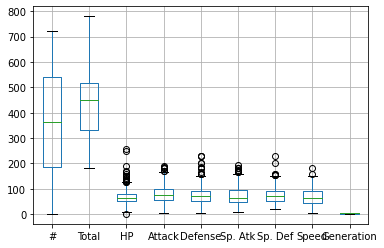

In [121]:
list_int_feature=[]
for feature in data.columns:
    if type(data[feature][0])==np.int64:
        list_int_feature.append(feature)
data.boxplot(column=list_int_feature)

# Clustering by unsupervised learning

In [122]:
def clustering_by_unsupervised_learning(data, feature1, feature2, class_to_predict):
    X = data[[feature1, feature2]]
    Y = data[class_to_predict]
    k=2
    plt.title("Two informative features, one cluster per class")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='o', c=Y, s=25, edgecolor='k')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    # K-mean
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    plt.title("K-MEAN")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=km.labels_)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    # Hierarchical clustering
    clusterings = []
    for linkage in ('ward', 'average', 'complete'):
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=k)
        clustering.fit(X)
        clusterings.append(clustering)
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.title("Hierarchical clustering ("+linkage+")")
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=clustering.labels_)
        plt.show()

    # Spectral clustering
    spectral = cluster.SpectralClustering(n_clusters=k, eigen_solver='arpack', affinity="nearest_neighbors")
    spectral.fit(X)
    plt.title("Spectral Clustering")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=spectral.labels_)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()
    
    return km, clusterings, spectral

In [125]:
def evaluation(km, clusterings, spectral, X, Y):
    # comparison of the three methods
    methods = ['K-MEAN', 'Clustering(Ward)', 'Clustering (Average)', 'Clustering (Complete)', 'Spectral Clustering']
    list_results = [km, clusterings[0], clusterings[1], clusterings[2], spectral]
    Scores_1 = [[], [], [], [], []]
    
    for result in list_results:
        Scores_1[0].append(metrics.homogeneity_score(Y, result.labels_))
        Scores_1[1].append(metrics.completeness_score(Y, result.labels_))
        Scores_1[2].append(metrics.v_measure_score(Y, result.labels_))
        Scores_1[3].append(metrics.adjusted_rand_score(Y, result.labels_))
        Scores_1[4].append(metrics.silhouette_score(X, result.labels_))
    
    for i in range(5):
        print(methods[i])
        print("Homogeneity :", Scores_1[0][i])
        print("Completeness :", Scores_1[1][i])
        print("V-measure :", Scores_1[2][i])
        print("Adjusted Rand-Index :", Scores_1[3][i])
        print("Silhouette Coefficient :", Scores_1[4][i], '\n')

## Test on stat total and each stat

HP


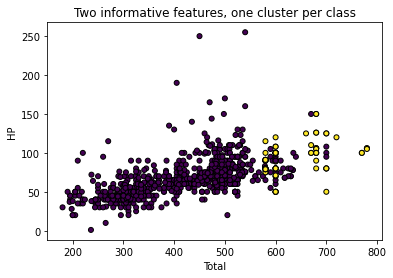

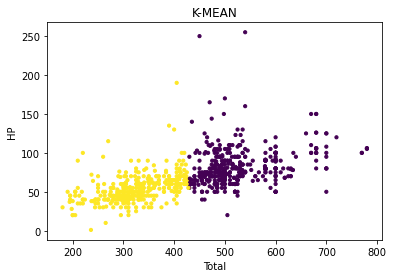

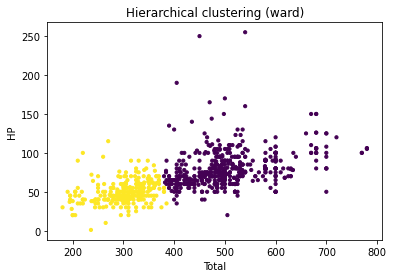

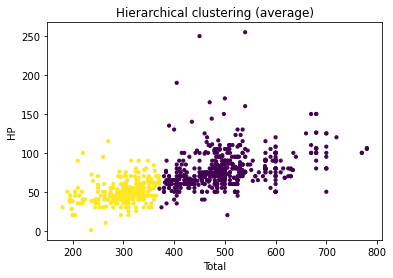

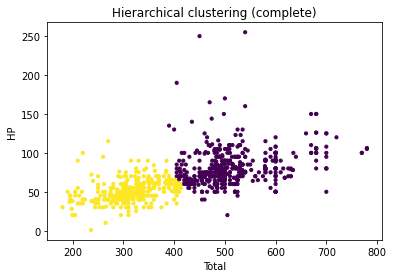

C:\Users\llego\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


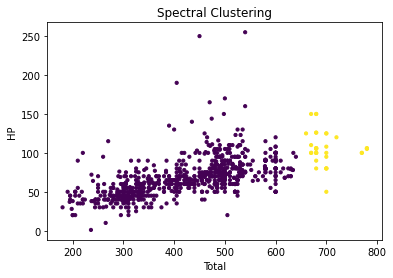

K-MEAN
Homogeneity : 0.20197974046963443
Completeness : 0.09098338622263255
V-measure : 0.12545470103204567
Adjusted Rand-Index : 0.010185490872474145
Silhouette Coefficient : 0.5884866317543347 

Clustering(Ward)
Homogeneity : 0.13870012737311277
Completeness : 0.06657284985080143
V-measure : 0.08996471799427434
Adjusted Rand-Index : -0.049634957606109566
Silhouette Coefficient : 0.5774062813151175 

Clustering (Average)
Homogeneity : 0.13434237865218812
Completeness : 0.06503678888733382
V-measure : 0.08764403048570947
Adjusted Rand-Index : -0.05313157348629672
Silhouette Coefficient : 0.5731338183014679 

Clustering (Complete)
Homogeneity : 0.1732150843323478
Completeness : 0.07936388712202075
V-measure : 0.10885326139090182
Adjusted Rand-Index : -0.018892642319885366
Silhouette Coefficient : 0.5849967113633112 

Spectral Clustering
Homogeneity : 0.2334156191592513
Completeness : 0.4224773323369503
V-measure : 0.30069787419799443
Adjusted Rand-Index : 0.45273515690693744
Silhouette 

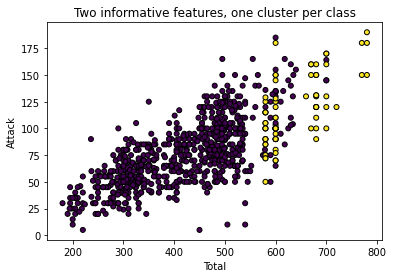

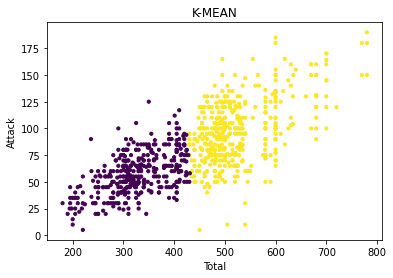

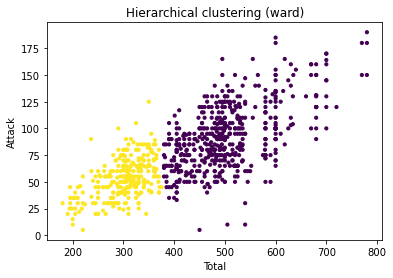

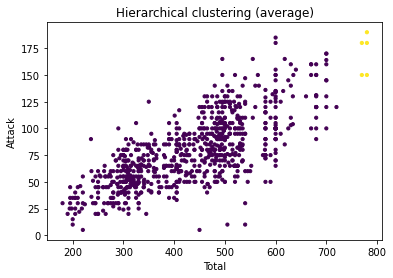

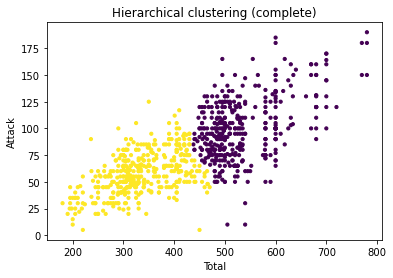

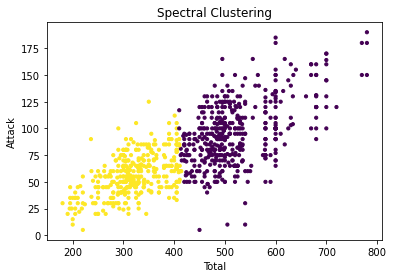

K-MEAN
Homogeneity : 0.2035317749356588
Completeness : 0.09163766659073222
V-measure : 0.12637606952619623
Adjusted Rand-Index : 0.011831561784165499
Silhouette Coefficient : 0.5777224119604248 

Clustering(Ward)
Homogeneity : 0.1355810193887003
Completeness : 0.06547174492613657
V-measure : 0.08830245083665826
Adjusted Rand-Index : -0.052147570744389374
Silhouette Coefficient : 0.5626498699837889 

Clustering (Average)
Homogeneity : 0.048173159068099165
Completeness : 0.39493991809621876
V-measure : 0.08587200187610823
Adjusted Rand-Index : 0.10346835536673281
Silhouette Coefficient : 0.5415261161987202 

Clustering (Complete)
Homogeneity : 0.22530926978008356
Completeness : 0.10113378613865794
V-measure : 0.13960400806116802
Adjusted Rand-Index : 0.035685865964282734
Silhouette Coefficient : 0.5630654944039248 

Spectral Clustering
Homogeneity : 0.18250068129921843
Completeness : 0.083012746258053
V-measure : 0.11411763908133028
Adjusted Rand-Index : -0.009814866871893877
Silhouette 

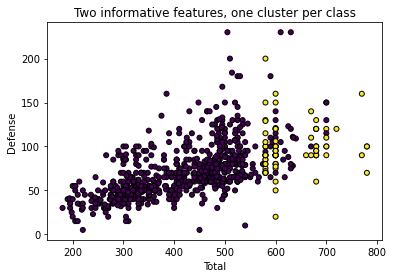

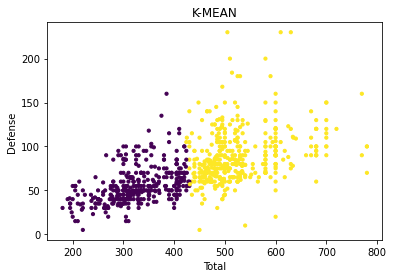

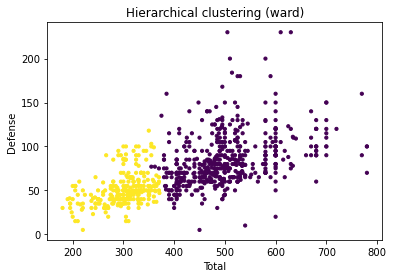

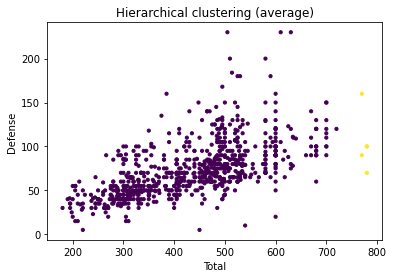

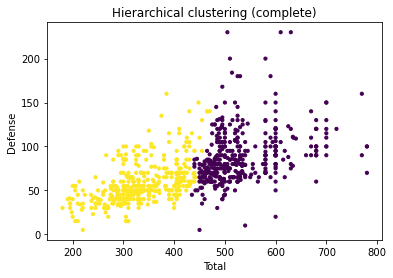

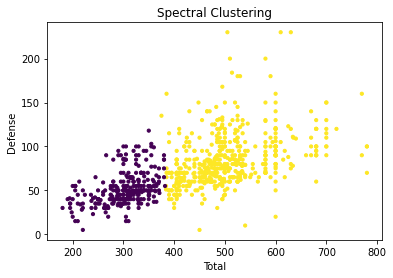

K-MEAN
Homogeneity : 0.20197974046963443
Completeness : 0.09098338622263255
V-measure : 0.12545470103204567
Adjusted Rand-Index : 0.010185490872474145
Silhouette Coefficient : 0.5748179754259694 

Clustering(Ward)
Homogeneity : 0.13310881871407346
Completeness : 0.06460490205846495
V-measure : 0.08698923031279186
Adjusted Rand-Index : -0.05410359039815363
Silhouette Coefficient : 0.5569835618692054 

Clustering (Average)
Homogeneity : 0.048173159068099165
Completeness : 0.39493991809621876
V-measure : 0.08587200187610823
Adjusted Rand-Index : 0.10346835536673281
Silhouette Coefficient : 0.528486533278963 

Clustering (Complete)
Homogeneity : 0.22115543022436154
Completeness : 0.09927598048357474
V-measure : 0.1370366414845766
Adjusted Rand-Index : 0.03103018597427142
Silhouette Coefficient : 0.5594327509434587 

Spectral Clustering
Homogeneity : 0.13870012737311277
Completeness : 0.06657284985080143
V-measure : 0.08996471799427434
Adjusted Rand-Index : -0.049634957606109566
Silhouette 

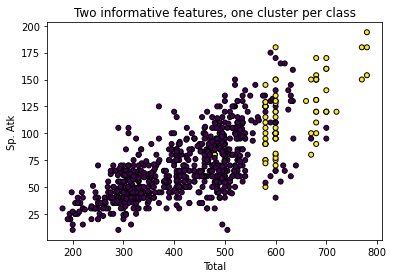

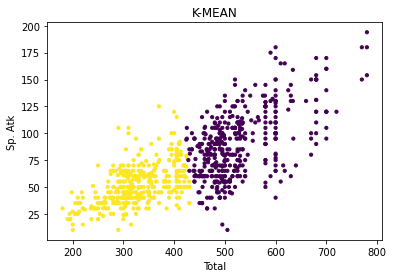

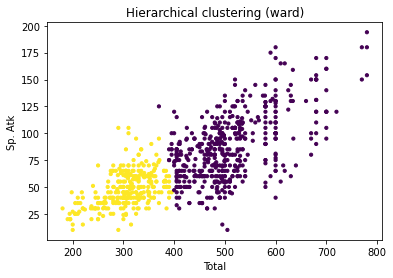

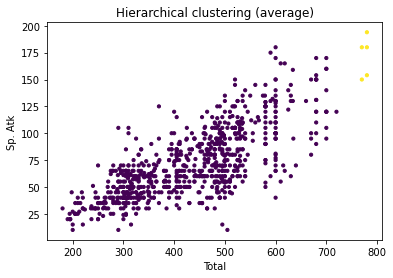

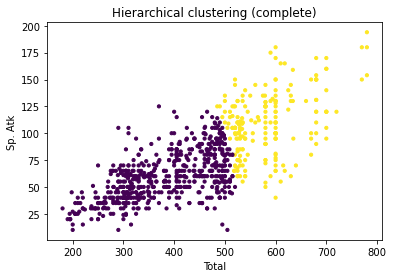

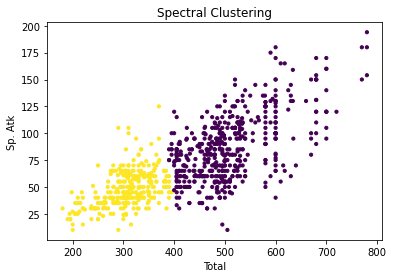

K-MEAN
Homogeneity : 0.202754755324716
Completeness : 0.091309740102797
V-measure : 0.12591444598839435
Adjusted Rand-Index : 0.011006530663680453
Silhouette Coefficient : 0.5762963191166675 

Clustering(Ward)
Homogeneity : 0.14632069633370182
Completeness : 0.06929910046424691
V-measure : 0.09405344765007431
Adjusted Rand-Index : -0.04329551054353527
Silhouette Coefficient : 0.5701938040621323 

Clustering (Average)
Homogeneity : 0.048173159068099165
Completeness : 0.39493991809621876
V-measure : 0.08587200187610823
Adjusted Rand-Index : 0.10346835536673281
Silhouette Coefficient : 0.5441638955170416 

Clustering (Complete)
Homogeneity : 0.42286839535978354
Completeness : 0.22855102879796538
V-measure : 0.2967274331144878
Adjusted Rand-Index : 0.33269250675218803
Silhouette Coefficient : 0.44356292802861375 

Spectral Clustering
Homogeneity : 0.14696454821985952
Completeness : 0.06953184424026623
V-measure : 0.0944007977181093
Adjusted Rand-Index : -0.04274733903007363
Silhouette Coef

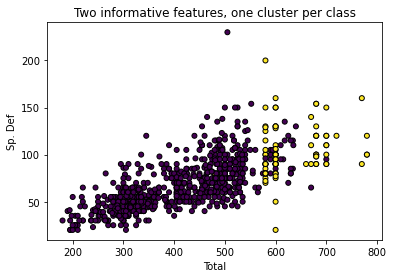

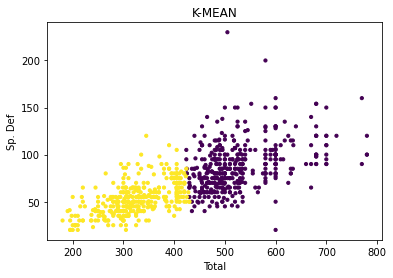

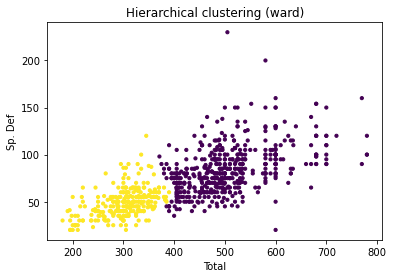

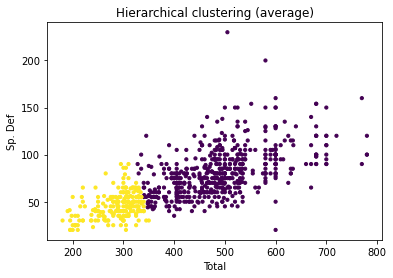

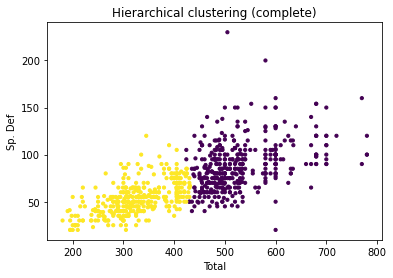

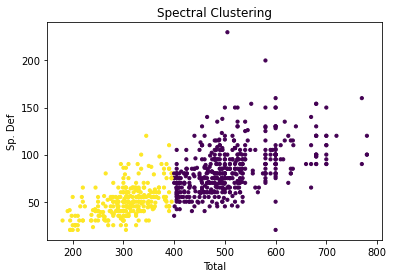

K-MEAN
Homogeneity : 0.19966662133995375
Completeness : 0.09001363975707576
V-measure : 0.12408659987217438
Adjusted Rand-Index : 0.00774614372121035
Silhouette Coefficient : 0.5857354404190425 

Clustering(Ward)
Homogeneity : 0.13932785013854251
Completeness : 0.06679546642778939
V-measure : 0.09030000963903762
Adjusted Rand-Index : -0.049123388234853405
Silhouette Coefficient : 0.5740395178345209 

Clustering (Average)
Homogeneity : 0.1060496109455007
Completeness : 0.05542614031595932
V-measure : 0.07280251766348178
Adjusted Rand-Index : -0.0731724650125851
Silhouette Coefficient : 0.5154379807812934 

Clustering (Complete)
Homogeneity : 0.20509187023098974
Completeness : 0.09229828639503
V-measure : 0.12730500828026395
Adjusted Rand-Index : 0.013493669588697466
Silhouette Coefficient : 0.5846744528272558 

Spectral Clustering
Homogeneity : 0.1521656085472948
Completeness : 0.07142611655840116
V-measure : 0.09721825337803833
Adjusted Rand-Index : -0.03825043426109538
Silhouette Coef

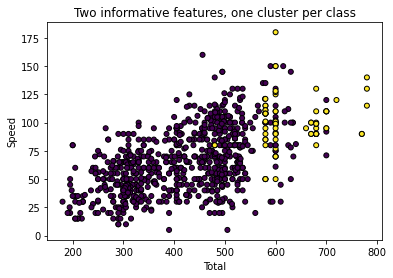

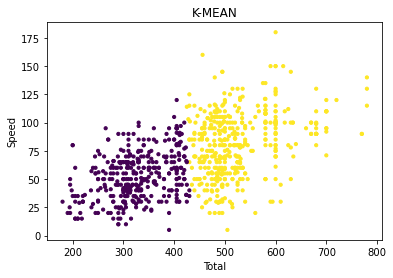

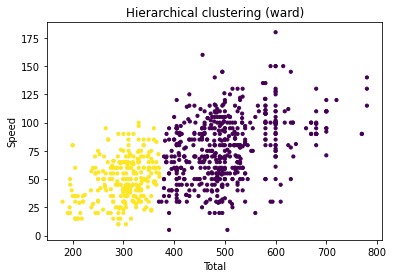

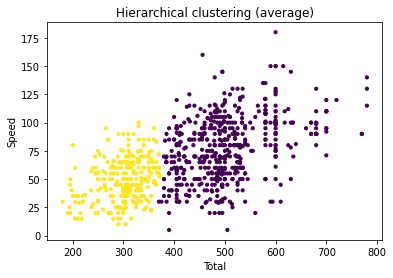

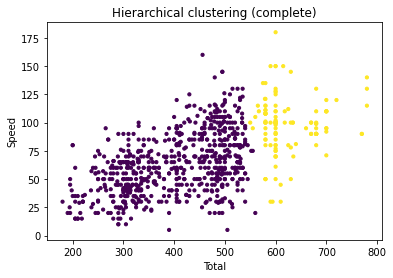

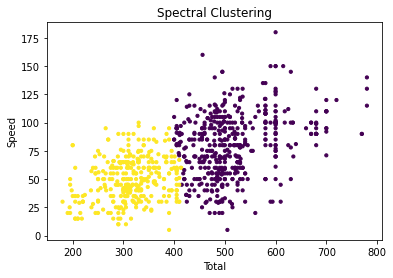

K-MEAN
Homogeneity : 0.20197974046963443
Completeness : 0.09098338622263255
V-measure : 0.12545470103204567
Adjusted Rand-Index : 0.010185490872474145
Silhouette Coefficient : 0.5724959969056624 

Clustering(Ward)
Homogeneity : 0.13434237865218812
Completeness : 0.06503678888733382
V-measure : 0.08764403048570947
Adjusted Rand-Index : -0.05313157348629672
Silhouette Coefficient : 0.5563704324650179 

Clustering (Average)
Homogeneity : 0.13434237865218812
Completeness : 0.06503678888733382
V-measure : 0.08764403048570947
Adjusted Rand-Index : -0.05313157348629672
Silhouette Coefficient : 0.5563704324650179 

Clustering (Complete)
Homogeneity : 0.6488514344049406
Completeness : 0.47757808906516713
V-measure : 0.5501937257036524
Adjusted Rand-Index : 0.6729386087802863
Silhouette Coefficient : 0.442997975331963 

Spectral Clustering
Homogeneity : 0.16902430654829628
Completeness : 0.07774743006964206
V-measure : 0.10650494771837779
Adjusted Rand-Index : -0.022886113697504117
Silhouette Co

In [127]:
for feature in ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    print(feature)
    km, clusterings, spectral = clustering_by_unsupervised_learning(data, 'Total', feature, 'Legendary')
    evaluation(km, clusterings, spectral, data[['Total', feature]], data['Legendary'])

# DECISIONS TREE

In [5]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
feature_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
clf = clf.fit(data[feature_int], data['Legendary'])
class_pred_DT = clf.predict(data[feature_int])

In [6]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_int, 
                                class_names=['Not Legendary', 'Legendary'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('Lengendary status (entropy)')

'Lengendary status (entropy).pdf'

In [11]:
data[feature_int]

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,318,45,49,49,65,65,45
1,405,60,62,63,80,80,60
2,525,80,82,83,100,100,80
3,625,80,100,123,122,120,80
4,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50
796,700,50,160,110,160,110,110
797,600,80,110,60,150,130,70
798,680,80,160,60,170,130,80


In [23]:
print(clf.decision_path([[700, 100, 180, 120, 30, 70, 200]]))

  (0, 0)	1
  (0, 12)	1
  (0, 13)	1
  (0, 15)	1


C:\Users\llego\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [16]:
print(Counter(data['HP']))

Counter({60: 67, 50: 63, 70: 57, 65: 46, 80: 43, 75: 43, 45: 38, 40: 38, 55: 37, 100: 32, 90: 27, 95: 22, 85: 19, 35: 15, 30: 13, 105: 10, 78: 9, 110: 9, 44: 7, 79: 7, 91: 7, 68: 7, 62: 7, 58: 6, 59: 6, 38: 6, 20: 6, 64: 6, 106: 5, 72: 5, 76: 5, 67: 5, 74: 5, 61: 4, 73: 4, 125: 4, 150: 4, 86: 4, 71: 4, 108: 4, 54: 4, 63: 3, 83: 3, 115: 3, 130: 3, 48: 3, 41: 3, 43: 3, 66: 3, 77: 3, 49: 3, 103: 3, 120: 3, 89: 3, 39: 2, 46: 2, 25: 2, 52: 2, 84: 2, 53: 2, 57: 2, 69: 2, 123: 2, 82: 2, 126: 2, 81: 1, 140: 1, 10: 1, 250: 1, 160: 1, 190: 1, 255: 1, 28: 1, 31: 1, 1: 1, 104: 1, 144: 1, 170: 1, 99: 1, 37: 1, 97: 1, 111: 1, 135: 1, 116: 1, 36: 1, 51: 1, 114: 1, 165: 1, 109: 1, 92: 1, 56: 1, 88: 1, 101: 1, 42: 1})


<function matplotlib.pyplot.show(close=None, block=None)>

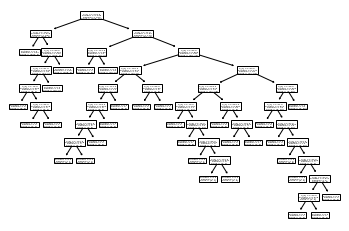

In [27]:
tree.plot_tree(clf)
plt.show

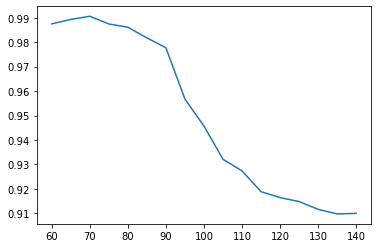

In [67]:
rate_common = []
for i in range(60, 145, 5):
    rate_common.append(len(commons[commons['Speed']<i])/len(data[data['Speed']<i]))
plt.plot(range(60, 145, 5), rate_common)
plt.show()

In [120]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(data[feature_int], data['Legendary'])
class_pred_RF = clf.predict(data[feature_int])

In [122]:
importance = clf.feature_importances_
print(importance)

[0.39073476 0.08393827 0.04904614 0.06680186 0.18185804 0.08710185
 0.14051906]


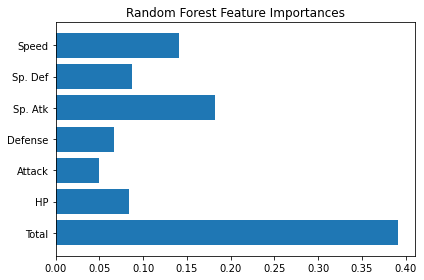

In [125]:
y_ticks = np.arange(0, len(feature_int))
fig, ax = plt.subplots()
ax.barh(y_ticks, importance)
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_int)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

# LOGISTIC REGRESSION

In [96]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 1e40)
clf.fit(data[features_int], data['Legendary'])
print(clf.coef_)

[[10.53944942 10.53759017  4.69996252  9.13588572]]


In [131]:
#data = pd.read_csv('data/Pokemon.csv')
data = pd.read_csv('data/pokemon_dataset_2.csv')
#features_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
features_int = ['Total', 'base_egg_steps', 'base_happiness', 'experience_growth']
print(features_int, '\n')
normalize_features(data, features_int)
updateTypeColumn(data, 'Legendary', True)
data['Legendary'] = data['Legendary'].apply(int) # Converts column to int
data = data[features_int+['Legendary']]

#accuracy, error = K_fold_logistic_regression(data, features_int, 'Legendary', 5, iterations=4000)
accuracy, error, theta = K_fold_logistic_regression(data, features_int, 'Legendary', 5, iterations=4000, N=10)
print('\nAverage accuracy :', accuracy)
print('Average error :', error)
print('Average Theta :', theta)

2 / 10


KeyboardInterrupt: 

In [58]:
dict((features_int[i], theta[i]) for i in range(len(features_int)))

{'Total': -0.29034764495973714,
 'base_egg_steps': 0.2449723325852859,
 'base_happiness': -0.3599471360710367,
 'experience_growth': -0.5550623401290578}

In [49]:
print(data[features_int].iloc[149, :])
n = np.dot(np.transpose(theta), data[features_int].iloc[149, :])
print(n, sigmoid(n))

Total                1.000000
base_egg_steps       1.000000
base_happiness       0.000000
experience_growth    0.762195
Name: 149, dtype: float64
0.41646569919165927 0.6026372141738523


In [59]:
for i in range(800):
    n = np.dot(np.transpose(theta), data[features_int].iloc[i, :])
    if sigmoid(n)>=0.5:
        print(i)

In [179]:
from src.logistic_regression import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [130]:
def normalize_features(data, features):
    for feature in features:
        data[feature] = data[feature].div(max(data[feature]), axis=0)
    return data

In [195]:
def liam_method(data, corr, constant):
    pred = []
    for i in range(len(data.iloc[:,0])):
        n = np.dot(np.transpose(corr), data[features_int].iloc[i, :])
        if n-constant>=0:
            pred.append(1)
        else:
            pred.append(0)
    return pred

def test_lm(pred, Y):
    TP, FP, TN, FN = 0, 0, 0, 0
    Y = list(Y)
    for i in range(len(pred)):
        if pred[i]==Y[i]:
            if pred[i]==1:
                TP+=1
            else:
                TN+=1
        else:
            if pred[i]==1:
                FP+=1
            else:
                FN+=1
    acc = (TP+TN)/len(Y)
    pre = TP/max(1, (TP+FP))
    rec = TP/(TP+FN)
    f_score = 2*pre*rec/max(1, (pre+rec))
    return acc, pre, rec, f_score

def K_fold_liam_method(data, features, target, k, N, constant):
    Accuracy, Precision, Recall, F_score = [], [], [], []
    for it in range(N):
        clear_output()
        print(it+1, '/', N)
        data = data.sample(frac=1)
        X = data[features]
        Y = data[target]
        n = len(X)
        for i in range(k):
            start = int(i*n/k)
            end = int((i+1)*n/k)
            X_test, X_train = X.iloc[start:end, :], pd.concat([X.iloc[:start, :], X.iloc[end:, :]], axis=0)
            Y_test, Y_train = Y.iloc[start:end], pd.concat([Y.iloc[:start], Y.iloc[end:]], axis=0)
            corr = pd.concat([X_train, Y_train], axis=1).corr()[target][features_int]
            pred = liam_method(X_test, corr, constant)
            acc, pre, rec, f_score = test_lm(pred, Y_test)
            Accuracy.append(acc)
            Precision.append(pre)
            Recall.append(rec)
            F_score.append(f_score)
    return np.mean(Accuracy), np.mean(Precision), np.mean(Recall), np.mean(F_score)

In [199]:
#data = pd.read_csv('data/Pokemon.csv')
data = pd.read_csv('data/pokemon_dataset_2.csv')
features_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
#features_int = ['Total', 'base_egg_steps', 'base_happiness', 'experience_growth']
print(features_int, '\n')
normalize_features(data, features_int)
updateTypeColumn(data, 'Legendary', True)
data['Legendary'] = data['Legendary'].apply(int) # Converts column to int
data = data[features_int+['Legendary']]

['Attack', 'base_egg_steps', 'base_happiness', 'Total', 'capture_rate', 'Defense', 'experience_growth', 'HP', 'Sp. Atk', 'Sp. Def', 'Speed'] 



10 / 10


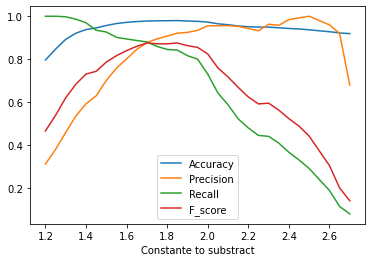

In [200]:
Accuracy, Precision, Recall, F_score = [], [], [], []
for l in np.arange(1.2, 2.7, 0.05):
    acc, pre, rec, f_score = K_fold_liam_method(data, features_int, 'Legendary', 5, 10, l)
    Accuracy.append(acc)
    Precision.append(pre)
    Recall.append(rec)
    F_score.append(f_score)
plt.plot(np.arange(1.2, 2.7, 0.05), Accuracy, label='Accuracy')
plt.plot(np.arange(1.2, 2.7, 0.05), Precision, label='Precision')
plt.plot(np.arange(1.2, 2.7, 0.05), Recall, label='Recall')
plt.plot(np.arange(1.2, 2.7, 0.05), F_score, label='F_score')
plt.legend()
plt.xlabel("Constante to substract")
plt.show()

10 / 10


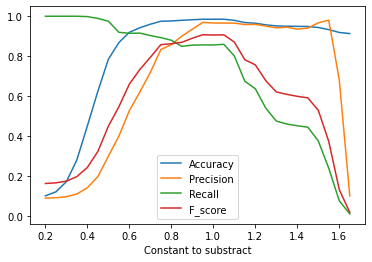

In [198]:
Accuracy, Precision, Recall, F_score = [], [], [], []
for l in np.arange(0.2, 1.7, 0.05):
    acc, pre, rec, f_score = K_fold_liam_method(data, features_int, 'Legendary', 5, 10, l)
    Accuracy.append(acc)
    Precision.append(pre)
    Recall.append(rec)
    F_score.append(f_score)
plt.plot(np.arange(0.2, 1.7, 0.05), Accuracy, label='Accuracy')
plt.plot(np.arange(0.2, 1.7, 0.05), Precision, label='Precision')
plt.plot(np.arange(0.2, 1.7, 0.05), Recall, label='Recall')
plt.plot(np.arange(0.2, 1.7, 0.05), F_score, label='F_score')
plt.legend()
plt.xlabel("Constant to substract")
plt.show()